In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Data waktu antar gempa (misal dalam jam)
tau = np.array([0.2, 0.5, 1.1, 0.9, 0.8, 0.7, 2.0, 0.3])

# Menghitung rata-rata waktu antar gempa
mean_tau = np.mean(tau)

# Normalisasi waktu antar gempa
theta = tau / mean_tau

# Menghitung distribusi probabilitas (misal dengan histogram density)
hist, bin_edges = np.histogram(theta, bins=np.logspace(-4, 1, 20), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fitting distribusi gamma
params = stats.gamma.fit(theta, floc=0)
alpha, loc, beta = params

# Membuat distribusi gamma yang di-fit
x = np.logspace(-4, 1, 100)
pdf_fitted = stats.gamma.pdf(x, alpha, loc, beta)

# Plot data histogram dan distribusi gamma
plt.figure(figsize=(8, 6))
plt.plot(x, pdf_fitted, 'k-', label='gamma distribution')
plt.scatter(bin_centers, hist, label='Data', color='red', alpha=0.6)

# Mengatur skala logaritmik untuk sumbu x dan y
plt.xscale('log')
plt.yscale('log')

# Label dan legend
plt.xlabel('Normalized inter-event time θ')
plt.ylabel('P(θ)')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'scipy'

Mc yang dihitung dengan metode Maximum Curvature: 0.20
Jumlah data setelah filter Mc: 54


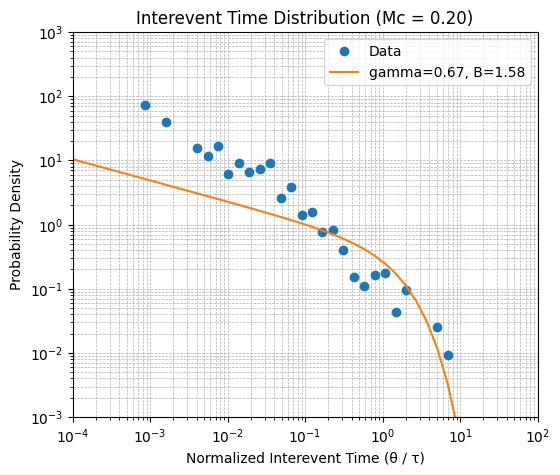

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = r"D:\TA\CODE\Main Python\MEQHULULAIS.txt"
data = pd.read_csv(file_path, sep='\t', header=None, 
                   names=['year', 'month', 'day', 'hour', 'min', 'sec', 
                          'latitude', 'longitude', 'depth', 'mag'])

data["timestamp"] = pd.to_datetime(
    data["year"].astype(str) + "-" + data["month"].astype(str).str.zfill(2) + "-" +
    data["day"].astype(str).str.zfill(2) + " " + data["hour"].astype(str).str.zfill(2) + ":" +
    data["min"].astype(str).str.zfill(2) + ":" + data["sec"].astype(str)
)
data = data.sort_values("timestamp")

magnitudes = data["mag"].values
bins = np.arange(magnitudes.min(), magnitudes.max() + 0.1, 0.1)
hist, bin_edges = np.histogram(magnitudes, bins=bins)
Mc = bin_edges[np.argmax(hist)]
print(f"Mc yang dihitung dengan metode Maximum Curvature: {Mc:.2f}")

filtered_data = data[data["mag"] > Mc]
print(f"Jumlah data setelah filter Mc: {len(filtered_data)}")

if len(filtered_data) > 1:
    interevent_times = filtered_data["timestamp"].diff().dt.total_seconds().dropna()
    tau = interevent_times.mean()
    normalized_times = interevent_times / tau
    
    time_bins = np.logspace(np.log10(normalized_times.min()), np.log10(normalized_times.max()), 50)
    counts, bin_edges = np.histogram(normalized_times, bins=time_bins, density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    C, gamma, B = 0.5, 0.67, 1.58
    custom_pdf = C * bin_centers**(gamma - 1) * np.exp(-bin_centers / B)
    
    plt.figure(figsize=(6, 5))
    plt.plot(bin_centers, counts, 'o', label="Data")
    plt.plot(bin_centers, custom_pdf, label=f"gamma={gamma:.2f}, B={B:.2f}")
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlim(1e-4, 1e2)
    plt.ylim(1e-3, 1e3)
    
    plt.xlabel("Normalized Interevent Time (θ / τ)")
    plt.ylabel("Probability Density")
    plt.title(f"Interevent Time Distribution (Mc = {Mc:.2f})")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()


Mean Correlation Dimension: 1.310
Max Correlation Dimension: 5.472


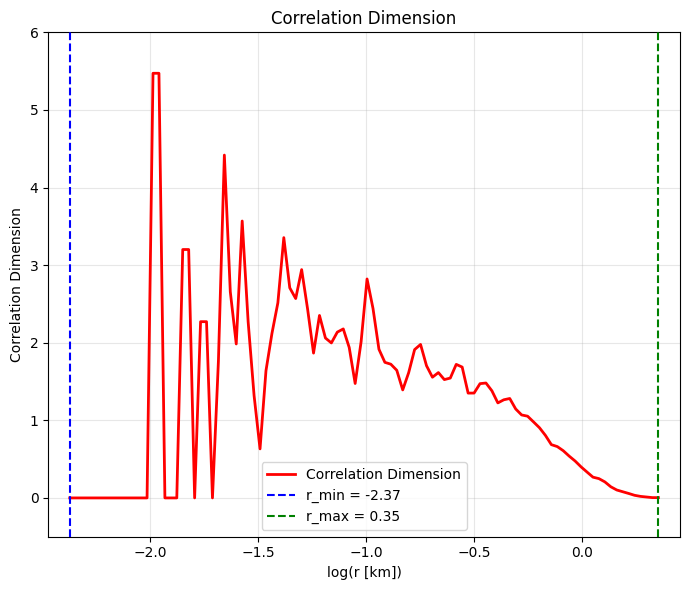

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

data = np.loadtxt("MEQHULULAIS.txt", skiprows=1)
coords = np.radians(data[:, 6:8])
distances = 2 * 6371 * np.arcsin(np.clip(pdist(coords) / 2, -1, 1))

r_min, r_max = np.log10(np.min(distances[distances > 0])), np.log10(np.max(distances))
r_bins = np.linspace(r_min, r_max, 100)

N = len(distances)
C_r = [(2.0 * np.sum(distances <= 10**r)) / (N * (N-1)) for r in r_bins]
d_corr = np.gradient(np.log10(np.clip(C_r, 1e-10, None)), r_bins)

print(f"Mean Correlation Dimension: {np.mean(d_corr):.3f}")
print(f"Max Correlation Dimension: {np.max(d_corr):.3f}")

plt.figure(figsize=(7, 6))
plt.grid(True, alpha=0.3)
plt.plot(r_bins, d_corr, 'r-', label='Correlation Dimension', linewidth=2)
plt.axvline(x=r_min, color='blue', linestyle='--', label=f'r_min = {r_min:.2f}', zorder=5)
plt.axvline(x=r_max, color='green', linestyle='--', label=f'r_max = {r_max:.2f}', zorder=5)
plt.xlabel('log(r [km])')
plt.ylabel('Correlation Dimension')
plt.title('Correlation Dimension')
plt.legend()
plt.ylim(-0.5, 6)
plt.xlim(r_min - 0.1, r_max + 0.1)
plt.tight_layout()
plt.show()

In [56]:
import os
import pandas as pd

def txt_to_excel_simple(input_folder, output_file):
    try:
        # Daftar nama file untuk pelacakan
        processed_files = []

        with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
            for file_name in os.listdir(input_folder):
                if file_name.endswith('.txt'):
                    txt_file = os.path.join(input_folder, file_name)

                    # Membaca file .txt
                    try:
                        with open(txt_file, 'r') as f:
                            lines = f.readlines()
                            if not lines:
                                print(f"File kosong: {file_name}, dilewati.")
                                continue
                    except Exception as e:
                        print(f"Gagal membaca file {file_name}: {e}")
                        continue
                    
                    # Menulis semua baris ke dalam DataFrame
                    data = {"Content": [line.strip() for line in lines]}  # Hilangkan spasi di awal/akhir
                    df = pd.DataFrame(data)

                    # Menulis DataFrame ke Excel
                    sheet_name = os.path.splitext(file_name)[0][:31]  # Membatasi nama sheet max 31 karakter
                    try:
                        df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)
                        processed_files.append(file_name)
                    except Exception as e:
                        print(f"Gagal menulis sheet untuk {file_name}: {e}")

        if processed_files:
            print(f"Berhasil mengonversi {len(processed_files)} file .txt ke Excel '{output_file}'")
        else:
            print("Tidak ada file yang berhasil dikonversi. Pastikan file .txt valid.")

    except Exception as e:
        print(f"Terjadi kesalahan saat membuat file Excel: {e}")

# Contoh penggunaan
input_folder = r'D:\TA\DATA\Hasil fix\Hasil\txtnya'  # Ganti dengan folder berisi file .txt
output_file = r'D:\TA\DATA\Hasil fix\Hasil\txtnya\combined_output.xlsx'  # Ganti dengan lokasi output

txt_to_excel_simple(input_folder, output_file)

Terjadi kesalahan saat membuat file Excel: At least one sheet must be visible


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def parse_time_to_seconds(time_str):
    """Convert time string to seconds."""
    minutes, seconds = map(float, time_str.split(':'))
    return minutes * 60 + seconds

def create_wadati_diagram(file_path):
    # Read data
    df = pd.read_csv(file_path, sep='\t', parse_dates=['DATE'])
    
    # Convert times to seconds
    df['TP_sec'] = df['TP'].apply(parse_time_to_seconds)
    df['TS_sec'] = df['TS'].apply(parse_time_to_seconds)
    
    # Calculate TS-TP
    df['TS_minus_TP'] = df['TS_sec'] - df['TP_sec']
    
    # Prepare plot
    plt.figure(figsize=(10, 6))
    
    # Scatter plot
    plt.scatter(df['TP_sec'], df['TS_sec'], alpha=0.7)
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['TP_sec'], df['TS_sec'])
    
    # Regression line
    x_line = np.array([df['TP_sec'].min(), df['TP_sec'].max()])
    y_line = slope * x_line + intercept
    plt.plot(x_line, y_line, color='red', linestyle='--', 
             label=f'Regression (slope = {slope:.4f})')
    
    # 45-degree line
    max_time = max(df['TP_sec'].max(), df['TS_sec'].max())
    plt.plot([0, max_time], [0, max_time], color='green', linestyle=':', label='45° Line')
    
    plt.xlabel('P-wave Arrival Time (seconds)')
    plt.ylabel('S-wave Arrival Time (seconds)')
    plt.title('Wadati Diagram')
    plt.legend()
    plt.grid(True)
    
    # Additional statistics
    print(f"Vp/Vs Ratio (from slope): {slope}")
    print(f"R-squared: {r_value**2:.4f}")
    print(f"Average TS-TP: {df['TS_minus_TP'].mean():.4f} seconds")
    
    plt.tight_layout()
    plt.show()

# Use the function
create_wadati_diagram('WADATI.txt')

FileNotFoundError: [Errno 2] No such file or directory: 'WADATI.txt'

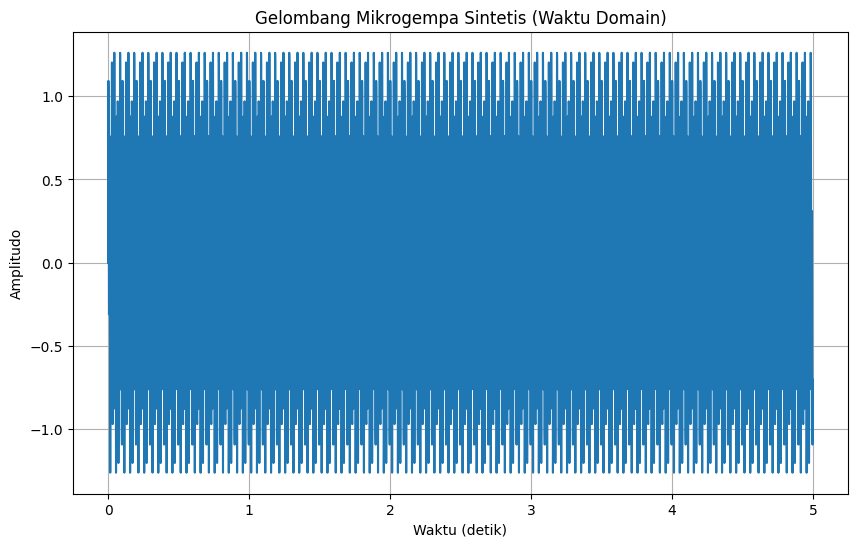

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter sinyal sintetis
sampling_rate = 1000  # Frekuensi sampling 1000 Hz
duration = 5  # durasi sinyal dalam detik
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Gelombang mikrogempa sintetis dengan dua frekuensi dominan
f1 = 50  # Frekuensi pertama (Hz)
f2 = 120  # Frekuensi kedua (Hz)
amplitude_1 = 0.5  # Amplitudo gelombang pertama
amplitude_2 = 0.8  # Amplitudo gelombang kedua

# Membuat sinyal gabungan
signal = amplitude_1 * np.sin(2 * np.pi * f1 * t) + amplitude_2 * np.sin(2 * np.pi * f2 * t)

# Plot gelombang waktu
plt.figure(figsize=(10, 6))
plt.plot(t, signal)
plt.title('Gelombang Mikrogempa Sintetis (Waktu Domain)')
plt.xlabel('Waktu (detik)')
plt.ylabel('Amplitudo')
plt.grid(True)
plt.show()


C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_25072\2560674742.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  output_data["Log10 Cumulative Frequency"].replace([-np.inf], np.nan, inplace=True)  # Ganti -inf dengan NaN


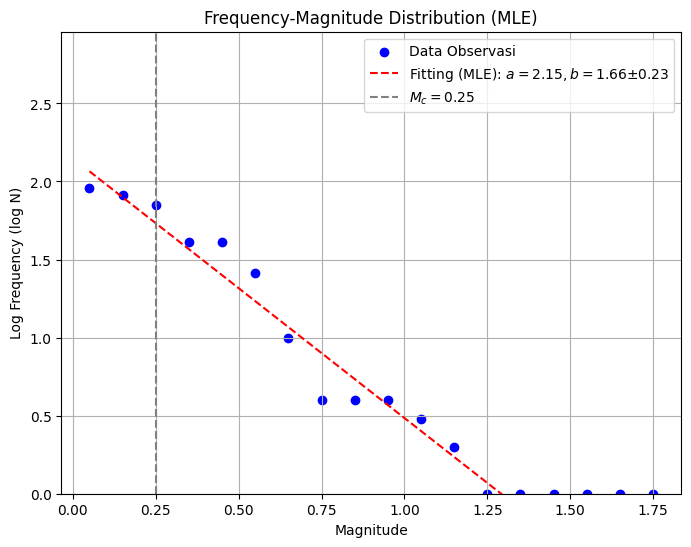

Magnitudo Completeness (M_c): 0.25
Jumlah event untuk M >= M_c: 54
Parameter hasil fitting (MLE): a = 2.15, b = 1.66 ± 0.23
Hasil analisis telah diekspor ke Frequency_Magnitude_Analysis.xlsx


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dari file TXT
file_path = "MEQHULULAIS.txt"  # File input
columns = ['year', 'month', 'day', 'hour', 'min', 'sec', 'lat', 'long', 'dept', 'mag']

# Membaca file dengan delimiter tab ("\t")
data = pd.read_csv(file_path, delimiter="\t", names=columns, skiprows=1)

# Gabungkan kolom waktu menjadi format datetime
data['time'] = pd.to_datetime(
    data['year'].astype(str) + '-' +
    data['month'].astype(str) + '-' +
    data['day'].astype(str) + ' ' +
    data['hour'].astype(str) + ':' +
    data['min'].astype(str) + ':' +
    data['sec'].astype(str),
    errors='coerce'
)

# Konversi kolom magnitude ke tipe numerik
data['mag'] = pd.to_numeric(data['mag'], errors='coerce')
magnitudes = data['mag'].dropna().values  # Hapus nilai NaN

# Langkah 1: Menentukan M_c menggunakan Maximum Curvature Method
def calculate_mc_maximum_curvature(magnitudes):
    bins = np.arange(0, np.max(magnitudes) + 0.1, 0.1)  # Interval magnitudo
    hist, bin_edges = np.histogram(magnitudes, bins=bins)
    M_centers = bin_edges[:-1] + 0.05  # Pusat setiap bin
    Mc_index = np.argmax(hist)  # Magnitudo dengan frekuensi maksimum
    return M_centers[Mc_index], M_centers, hist

Mc, M_centers, hist = calculate_mc_maximum_curvature(magnitudes)

# Langkah 2: Menghitung parameter a dan b menggunakan Maximum Likelihood
def calculate_b_and_a_mle(magnitudes, Mc):
    filtered_magnitudes = magnitudes[magnitudes >= Mc]  # Filter magnitudo >= Mc
    N = len(filtered_magnitudes)  # Jumlah data untuk M >= Mc
    if N == 0:
        raise ValueError("Tidak ada magnitudo di atas M_c. Harap cek dataset Anda.")
    mean_M = np.mean(filtered_magnitudes)  # Rata-rata magnitudo untuk M >= Mc
    b = np.log10(np.e) / (mean_M - Mc)  # Rumus b
    b_error = b / np.sqrt(N)  # Ketidakpastian b
    a = np.log10(N) + b * Mc  # Rumus a
    return a, b, b_error, N, filtered_magnitudes

a, b, b_error, N, filtered_magnitudes = calculate_b_and_a_mle(magnitudes, Mc)

# Langkah 3: Membuat distribusi kumulatif dan fitting Gutenberg-Richter
bins = np.arange(0, np.max(magnitudes) + 0.1, 0.1)
hist, bin_edges = np.histogram(magnitudes, bins=bins)
cumulative_counts = np.cumsum(hist[::-1])[::-1]
M_centers = bin_edges[:-1] + 0.05

# Ekspor hasil ke Excel
output_file = "Frequency_Magnitude_Analysis.xlsx"
output_data = pd.DataFrame({
    "Magnitude Bin Center": M_centers,
    "Frequency": hist,
    "Cumulative Frequency": cumulative_counts,
    "Log10 Cumulative Frequency": np.log10(cumulative_counts, where=(cumulative_counts > 0))
})
output_data["Log10 Cumulative Frequency"].replace([-np.inf], np.nan, inplace=True)  # Ganti -inf dengan NaN

# Tambahkan parameter hasil fitting
summary_data = pd.DataFrame({
    "Parameter": ["Mc", "a", "b", "b_error", "N"],
    "Value": [Mc, a, b, b_error, N]
})

# Tambahkan kolom magnitudo asli
original_data = pd.DataFrame({
    "Magnitude": magnitudes  # Semua magnitudo asli dari data
})

with pd.ExcelWriter(output_file) as writer:
    output_data.to_excel(writer, sheet_name="Magnitude Distribution", index=False)
    summary_data.to_excel(writer, sheet_name="Summary", index=False)
    original_data.to_excel(writer, sheet_name="Original Magnitudes", index=False)

# Plot distribusi
plt.figure(figsize=(8, 6))
plt.scatter(M_centers, np.log10(cumulative_counts, where=(cumulative_counts > 0)), color="blue", label="Data Observasi")
plt.plot(
    M_centers, a - b * M_centers, color="red", linestyle="--",
    label=f"Fitting (MLE): $a = {a:.2f}, b = {b:.2f} ± {b_error:.2f}$"
)
plt.axvline(x=Mc, color="gray", linestyle="--", label=f"$M_c = {Mc:.2f}$")
plt.xlabel("Magnitude")
plt.ylabel("Log Frequency (log N)")
plt.title("Frequency-Magnitude Distribution (MLE)")
plt.legend()
plt.grid(True)
plt.ylim(0, np.log10(np.max(cumulative_counts)) + 1)
plt.show()

# Debugging untuk memeriksa hasil
print(f"Magnitudo Completeness (M_c): {Mc}")
print(f"Jumlah event untuk M >= M_c: {N}")
print(f"Parameter hasil fitting (MLE): a = {a:.2f}, b = {b:.2f} ± {b_error:.2f}")
print(f"Hasil analisis telah diekspor ke {output_file}")


C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_1364\1968508368.py:72: RuntimeWarning: divide by zero encountered in log10
  I = np.where(~np.isnan(np.log10(eta_ij)) & (eta_ij > 0))[0]
C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_1364\1968508368.py:77: RuntimeWarning: divide by zero encountered in log10
  K, Ta, Xa = xymap(np.log10(TN), np.log10(RN), None, 's', 200, 200, [-12, 0], [-9, 0])


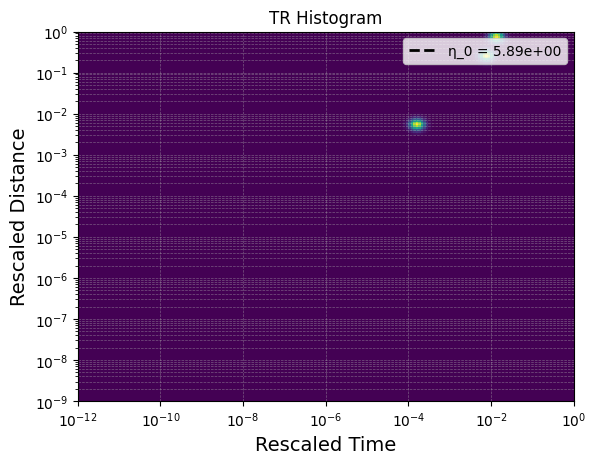

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter

# Fungsi untuk menghitung jarak berdasarkan koordinat (latitude dan longitude)
def latlonkm(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[:, 0])**2 + (coord1[1] - coord2[:, 1])**2)

# Fungsi untuk membuat peta x-y
def xymap(x, y, v=None, type='m', Nx=None, Ny=None, XLim=None, YLim=None):
    v = np.ones_like(x) if v is None else v
    minY, maxY = np.min(YLim if YLim is not None else y), np.max(YLim if YLim is not None else y)
    minX, maxX = np.min(XLim if XLim is not None else x), np.max(XLim if XLim is not None else x)
    
    I = np.where((x >= minX) & (x <= maxX) & (y >= minY) & (y <= maxY))
    x, y, v = x[I], y[I], v[I]
    
    stepx, stepy = (maxX - minX)/Nx, (maxY - minY)/Ny
    xn = np.maximum(np.ceil((x - minX)/stepx).astype(int), 1)
    yn = np.maximum(np.ceil((y - minY)/stepy).astype(int), 1)
    
    M = np.zeros((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            I = np.where((xn == i+1) & (yn == j+1))
            M[i, j] = np.nansum(v[I]) if type == 's' else np.nanmean(v[I])
    
    return M, np.linspace(minX, maxX, Nx), np.linspace(minY, maxY, Ny)

# Fungsi untuk perhitungan bp
def bp(time, mag, Lon, Lat, b, df, lag=None):
    lag = np.inf if lag is None else lag * 365.25 * 24 * 3600
    time = time * 365.25 * 24 * 3600
    P, n, T, D, M = np.zeros(len(time), dtype=int), np.full(len(time), np.inf), np.full(len(time), np.nan), np.full(len(time), np.nan), np.full(len(time), np.nan)
    RN, TN, eta_ij = np.full(len(time), np.nan), np.full(len(time), np.nan), np.full(len(time), np.nan)
    P[np.argmin(time)] = 0
    
    for i in range(len(time)):
        I = np.where((time < time[i]) & (time >= time[i] - lag))[0]
        if I.size > 0:
            d = np.maximum(latlonkm([Lat[i], Lon[i]], np.array([Lat[I], Lon[I]]).T) * 1000, 0)
            t = np.maximum(time[i] - time[I], 0)
            nc = t * d**1.3 * 10**(-1.83 * mag[I])
            n[i], imin = np.min(nc), np.argmin(nc)
            P[i], D[i], T[i], M[i] = I[imin], d[imin], t[imin], mag[I[imin]]
            RN[i] = D[i]**1.3 * 10**(-(0.5) * 1.8 * M[i])
            TN[i] = T[i] * 10**(-0.5 * 1.83 * M[i])
            eta_ij[i] = RN[i] * TN[i]
    
    return P, n, D/(1000), T/(365.25 * 24 * 3600), M, RN, TN, eta_ij

# Fungsi untuk menghitung hari dalam setahun
def day_of_year(year, month, day):
    days = [31,29 if (year%4==0 and year%100!=0) or year%400==0 else 28,31,30,31,30,31,31,30,31,30,31]
    return sum(days[:month-1]) + day

# Membaca data dari file
cat = pd.read_csv('/TA/CODE/Main Python/MEQHULULAISALL.txt', sep='\s+', header=None).values
year, month, day = cat[:, 0].astype(int), cat[:, 1].astype(int), cat[:, 2].astype(int)
hour, minute, sec = cat[:, 3].astype(int), cat[:, 4].astype(int), cat[:, 5].astype(float)
Lat, Lon, mag = cat[:, 6].astype(float), cat[:, 7].astype(float), cat[:, 9].astype(float)

# Menghitung waktu dalam tahun
time = np.array([year[i] + (day_of_year(year[i], month[i], day[i]) + hour[i]/24 + minute[i]/1440 + sec[i]/86400)/365.25 for i in range(len(year))])

# Menghitung parameter bp
P, n, D, T, M, RN, TN, eta_ij = bp(time, mag, Lon, Lat, 1.0, 1.6)

# Filter data untuk plotting
I = np.where(~np.isnan(np.log10(eta_ij)) & (eta_ij > 0))[0]
eta0 = 10**np.mean(GaussianMixture(n_components=2).fit(np.log10(eta_ij[I]).reshape(-1, 1)).means_.flatten())

# Membuat plot
plt.figure()
K, Ta, Xa = xymap(np.log10(TN), np.log10(RN), None, 's', 200, 200, [-12, 0], [-9, 0])
plt.pcolormesh(10**Ta, 10**Xa, gaussian_filter(K.T, sigma=2), shading='auto', cmap='viridis')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rescaled Time', fontsize=14)
plt.ylabel('Rescaled Distance', fontsize=14)
plt.title('TR Histogram')
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.xlim(10**-12, 10**0)
plt.ylim(10**-9, 10**0)

Tlog = np.logspace(-11, 0, 100)
plt.loglog(Tlog, eta0/Tlog, 'k--', linewidth=2, label=f'η_0 = {eta0:.2e}')
plt.legend()
plt.show()


C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_25072\2560674742.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  output_data["Log10 Cumulative Frequency"].replace([-np.inf], np.nan, inplace=True)  # Ganti -inf dengan NaN


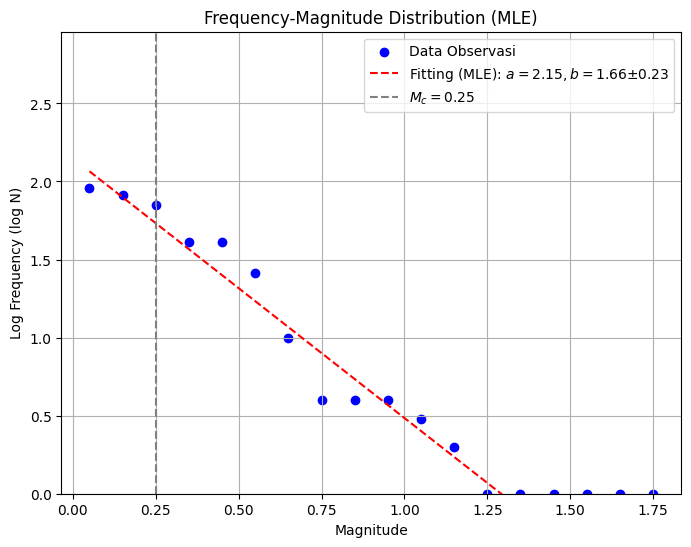

Magnitudo Completeness (M_c): 0.25
Jumlah event untuk M >= M_c: 54
Parameter hasil fitting (MLE): a = 2.15, b = 1.66 ± 0.23
Hasil analisis telah diekspor ke Frequency_Magnitude_Analysis.xlsx


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Membaca data dari file TXT
file_path = "MEQHULULAIS.txt"  # File input
columns = ['year', 'month', 'day', 'hour', 'min', 'sec', 'lat', 'long', 'dept', 'mag']

# Membaca file dengan delimiter tab ("\t")
data = pd.read_csv(file_path, delimiter="\t", names=columns, skiprows=1)

# Gabungkan kolom waktu menjadi format datetime
data['time'] = pd.to_datetime(
    data['year'].astype(str) + '-' +
    data['month'].astype(str) + '-' +
    data['day'].astype(str) + ' ' +
    data['hour'].astype(str) + ':' +
    data['min'].astype(str) + ':' +
    data['sec'].astype(str),
    errors='coerce'
)

# Konversi kolom magnitude ke tipe numerik
data['mag'] = pd.to_numeric(data['mag'], errors='coerce')
magnitudes = data['mag'].dropna().values  # Hapus nilai NaN

# Langkah 1: Menentukan M_c menggunakan Maximum Curvature Method
def calculate_mc_maximum_curvature(magnitudes):
    bins = np.arange(0, np.max(magnitudes) + 0.1, 0.1)  # Interval magnitudo
    hist, bin_edges = np.histogram(magnitudes, bins=bins)
    M_centers = bin_edges[:-1] + 0.05  # Pusat setiap bin
    Mc_index = np.argmax(hist)  # Magnitudo dengan frekuensi maksimum
    return M_centers[Mc_index], M_centers, hist

Mc, M_centers, hist = calculate_mc_maximum_curvature(magnitudes)

# Langkah 2: Menghitung parameter a dan b menggunakan Maximum Likelihood
def calculate_b_and_a_mle(magnitudes, Mc):
    filtered_magnitudes = magnitudes[magnitudes >= Mc]  # Filter magnitudo >= Mc
    N = len(filtered_magnitudes)  # Jumlah data untuk M >= Mc
    if N == 0:
        raise ValueError("Tidak ada magnitudo di atas M_c. Harap cek dataset Anda.")
    mean_M = np.mean(filtered_magnitudes)  # Rata-rata magnitudo untuk M >= Mc
    b = np.log10(np.e) / (mean_M - Mc)  # Rumus b
    b_error = b / np.sqrt(N)  # Ketidakpastian b
    a = np.log10(N) + b * Mc  # Rumus a
    return a, b, b_error, N, filtered_magnitudes

a, b, b_error, N, filtered_magnitudes = calculate_b_and_a_mle(magnitudes, Mc)

# Langkah 3: Membuat distribusi kumulatif dan fitting Gutenberg-Richter
bins = np.arange(0, np.max(magnitudes) + 0.1, 0.1)
hist, bin_edges = np.histogram(magnitudes, bins=bins)
cumulative_counts = np.cumsum(hist[::-1])[::-1]
M_centers = bin_edges[:-1] + 0.05

# Ekspor hasil ke Excel
output_file = "Frequency_Magnitude_Analysis.xlsx"
output_data = pd.DataFrame({
    "Magnitude Bin Center": M_centers,
    "Frequency": hist,
    "Cumulative Frequency": cumulative_counts,
    "Log10 Cumulative Frequency": np.log10(cumulative_counts, where=(cumulative_counts > 0))
})
output_data["Log10 Cumulative Frequency"].replace([-np.inf], np.nan, inplace=True)  # Ganti -inf dengan NaN

# Tambahkan parameter hasil fitting
summary_data = pd.DataFrame({
    "Parameter": ["Mc", "a", "b", "b_error", "N"],
    "Value": [Mc, a, b, b_error, N]
})

# Tambahkan kolom magnitudo asli
original_data = pd.DataFrame({
    "Magnitude": magnitudes  # Semua magnitudo asli dari data
})

with pd.ExcelWriter(output_file) as writer:
    output_data.to_excel(writer, sheet_name="Magnitude Distribution", index=False)
    summary_data.to_excel(writer, sheet_name="Summary", index=False)
    original_data.to_excel(writer, sheet_name="Original Magnitudes", index=False)

# Plot distribusi
plt.figure(figsize=(8, 6))
plt.scatter(M_centers, np.log10(cumulative_counts, where=(cumulative_counts > 0)), color="blue", label="Data Observasi")
plt.plot(
    M_centers, a - b * M_centers, color="red", linestyle="--",
    label=f"Fitting (MLE): $a = {a:.2f}, b = {b:.2f} ± {b_error:.2f}$"
)
plt.axvline(x=Mc, color="gray", linestyle="--", label=f"$M_c = {Mc:.2f}$")
plt.xlabel("Magnitude")
plt.ylabel("Log Frequency (log N)")
plt.title("Frequency-Magnitude Distribution (MLE)")
plt.legend()
plt.grid(True)
plt.ylim(0, np.log10(np.max(cumulative_counts)) + 1)
plt.show()

# Debugging untuk memeriksa hasil
print(f"Magnitudo Completeness (M_c): {Mc}")
print(f"Jumlah event untuk M >= M_c: {N}")
print(f"Parameter hasil fitting (MLE): a = {a:.2f}, b = {b:.2f} ± {b_error:.2f}")
print(f"Hasil analisis telah diekspor ke {output_file}")


C:\Users\MSI-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:1290: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\MSI-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:1291: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\MSI-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:1292: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Users\MSI-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:1298: RuntimeWarning: invalid valu

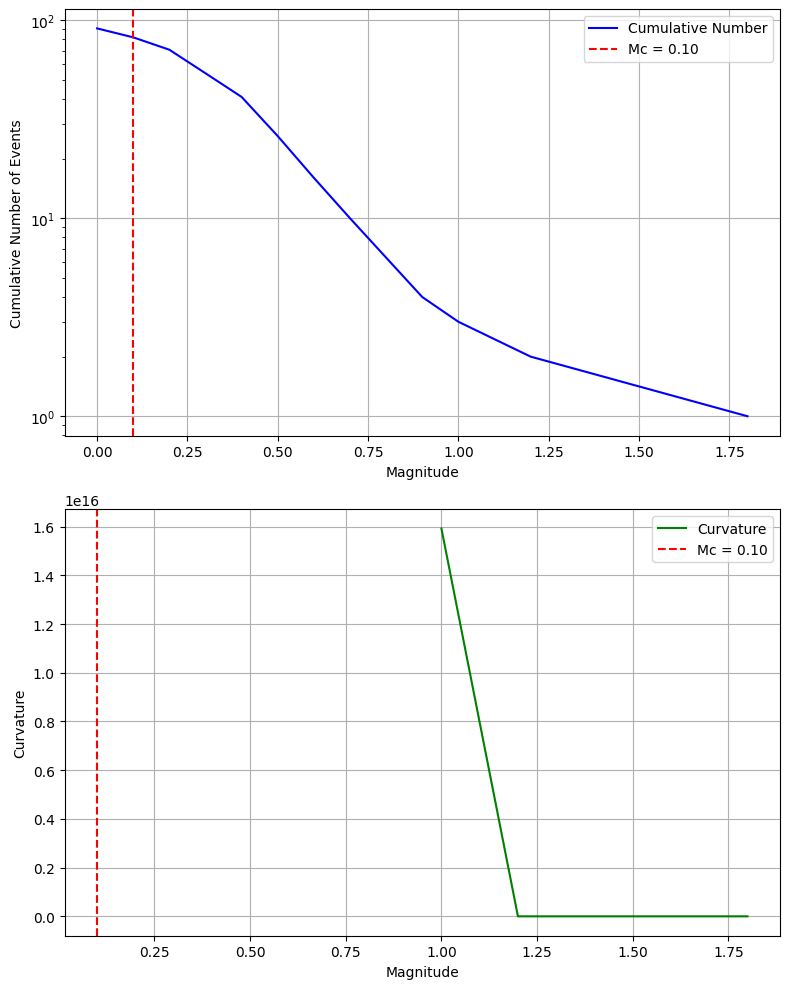

Magnitude of Completeness (Mc) using Maximum Curvature = 0.10


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

def calculate_mc_max_curvature(magnitudes):
    # Count unique magnitudes and their frequencies
    unique_mags, counts = np.unique(magnitudes, return_counts=True)
    cum_number = np.cumsum(counts[::-1])[::-1]
    
    # Compute curvature
    dx = np.gradient(unique_mags)
    dy = np.gradient(cum_number)
    d2y = np.gradient(dy, dx)
    curvature = np.abs(d2y / (1 + dy**2)**(3/2))
    
    # Find magnitude at maximum curvature
    mc_value = unique_mags[np.argmax(curvature)]
    
    return mc_value, unique_mags, cum_number, curvature

def plot_mc_analysis(filename):
    # Read data
    data = pd.read_csv(filename, sep='\t', header=None, 
                       names=['year', 'month', 'day', 'hour', 'min', 'sec', 
                              'latitude', 'longitude', 'depth', 'mag'])
    
    magnitudes = data['mag'].values
    
    # Calculate Mc
    mc_value, unique_mags, cum_number, curvature = calculate_mc_max_curvature(magnitudes)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
    
    # Cumulative plot
    ax1.plot(unique_mags, cum_number, 'b-', label='Cumulative Number')
    ax1.set_xlabel('Magnitude')
    ax1.set_ylabel('Cumulative Number of Events')
    ax1.set_yscale('log')
    ax1.axvline(x=mc_value, color='r', linestyle='--', label=f'Mc = {mc_value:.2f}')
    ax1.legend()
    ax1.grid(True)
    
    # Curvature plot
    ax2.plot(unique_mags, curvature, 'g-', label='Curvature')
    ax2.set_xlabel('Magnitude')
    ax2.set_ylabel('Curvature')
    ax2.axvline(x=mc_value, color='r', linestyle='--', label=f'Mc = {mc_value:.2f}')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return mc_value

# Run analysis
mc = plot_mc_analysis("MEQHULULAIS.txt")
print(f"Magnitude of Completeness (Mc) using Maximum Curvature = {mc:.2f}")

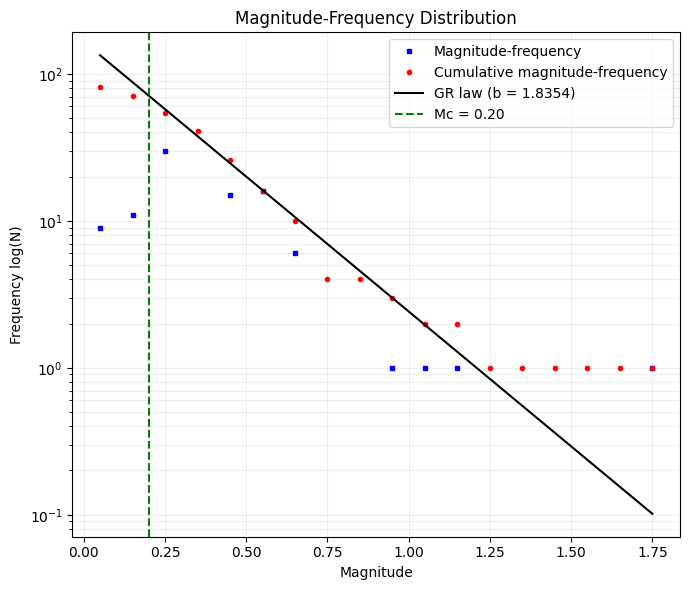


Hasil Analisis:
a-value = 2.2183
b-value = 1.8354
Magnitude of Completeness (Mc) = 0.20


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_gr_distribution(filepath):
    data = pd.read_csv(filepath, sep='\t', header=None, 
                       names=['year', 'month', 'day', 'hour', 'min', 'sec', 
                              'latitude', 'longitude', 'depth', 'mag'])
    
    magnitudes = data['mag'].values
    
    bins = np.arange(magnitudes.min(), magnitudes.max() + 0.1, 0.1)
    hist, bin_edges = np.histogram(magnitudes, bins=bins)
    mc_value = bin_edges[np.argmax(hist)]
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    cum_freq = np.array([np.sum(magnitudes >= mag) for mag in bin_centers])
    
    magnitudes_above_mc = magnitudes[magnitudes >= mc_value]
    if len(magnitudes_above_mc) > 0:
        b_value = np.log10(np.e) / (np.mean(magnitudes_above_mc) - mc_value)
        a_value = np.log10(len(magnitudes_above_mc)) + b_value * mc_value
    else:
        b_value, a_value = np.nan, np.nan
    
    plt.figure(figsize=(7, 6))
    plt.plot(bin_centers, hist, 'bs', label='Magnitude-frequency', markersize=3)
    plt.plot(bin_centers, cum_freq, 'ro', label='Cumulative magnitude-frequency', markersize=3)
    
    if not np.isnan(b_value):
        plt.plot(bin_centers, 10**(a_value - b_value * bin_centers), 'k-', 
                 label=f'GR law (b = {b_value:.4f})')
    plt.axvline(x=mc_value, color='g', linestyle='--', label=f'Mc = {mc_value:.2f}')
    
    plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.xlabel('Magnitude')
    plt.ylabel('Frequency log(N)')
    plt.title('Magnitude-Frequency Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {'a_value': a_value, 'b_value': b_value, 'mc_value': mc_value}

file_path = r"D:\TA\CODE\Main Python\MEQHULULAIS.txt"
results = plot_gr_distribution(file_path)
print(f"\nHasil Analisis:")
print(f"a-value = {results['a_value']:.4f}")
print(f"b-value = {results['b_value']:.4f}")
print(f"Magnitude of Completeness (Mc) = {results['mc_value']:.2f}")


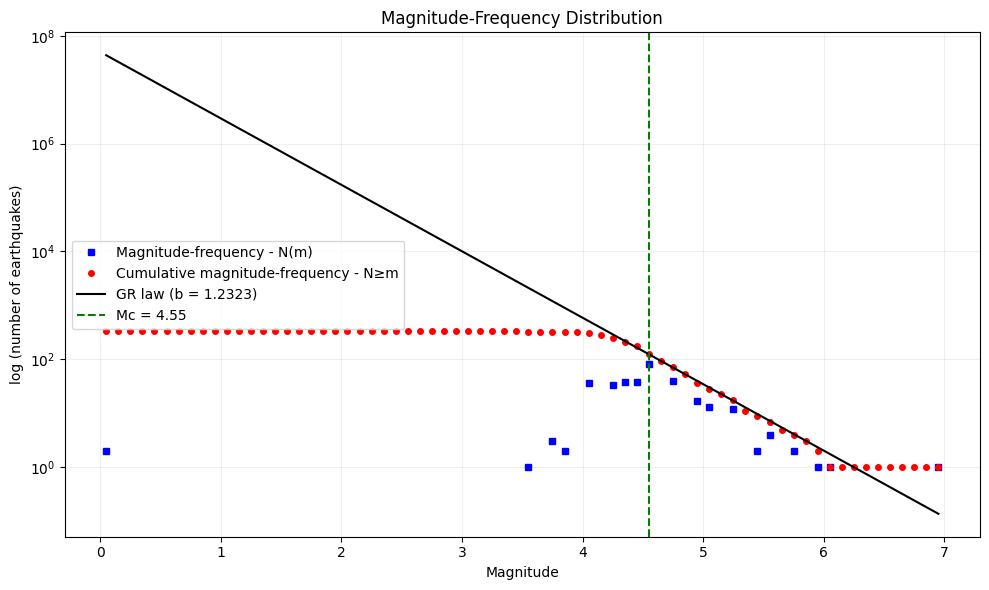


Hasil Analisis:
a-value = 7.7005
b-value = 1.2323
Magnitude of Completeness (Mc) = 4.55


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def read_data(filename):
    """
    Membaca data dari file CSV dengan magnitude di kolom ke-4
    """
    # Membaca file CSV dengan pandas
    df = pd.read_csv(filename)
    # Mengambil kolom magnitude (asumsi kolom ke-4 adalah indeks 3)
    magnitudes = df.iloc[:, 3].values
    return magnitudes

def calculate_frequency_distribution(magnitudes, bin_width=0.1):
    """
    Menghitung distribusi frekuensi magnitude
    """
    # Menentukan bins
    bins = np.arange(np.floor(min(magnitudes)), np.ceil(max(magnitudes)) + bin_width, bin_width)
    # Menghitung histogram
    hist, bin_edges = np.histogram(magnitudes, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Menghitung frekuensi kumulatif
    cum_freq = np.array([np.sum(magnitudes >= mag) for mag in bin_centers])

    return bin_centers, hist, cum_freq

def calculate_mc_and_b_a(magnitudes, bin_width=0.1):
    """
    Menghitung Mc, b-value, dan a-value berdasarkan rumus yang diberikan
    """
    # Menghitung Mc sebagai nilai magnitude dengan frekuensi tertinggi
    bins = np.arange(np.floor(min(magnitudes)), np.ceil(max(magnitudes)) + bin_width, bin_width)
    hist, bin_edges = np.histogram(magnitudes, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mc_index = np.argmax(hist)
    mc_value = bin_centers[mc_index]  # Magnitude of Completeness (Mc)

    # Data magnitudes yang >= Mc
    magnitudes_above_mc = magnitudes[magnitudes >= mc_value]
    mean_m = np.mean(magnitudes_above_mc)
    N = len(magnitudes_above_mc)

    # Menghitung b-value
    b_value = np.log10(np.e) / (mean_m - mc_value)

    # Menghitung a-value
    a_value = np.log10(N) + b_value * mc_value

    return mc_value, b_value, a_value

def plot_gr_distribution(filename):
    """
    Membuat plot distribusi Gutenberg-Richter
    """
    # Membaca data
    magnitudes = read_data(filename)

    # Menghitung distribusi frekuensi
    mag_bins, freq, cum_freq = calculate_frequency_distribution(magnitudes)

    # Menghitung Mc, b, dan a
    mc_value, b_value, a_value = calculate_mc_and_b_a(magnitudes)

    # Membuat plot
    plt.figure(figsize=(10, 6))

    # Plot frekuensi magnitude
    plt.plot(mag_bins, freq, 'bs', label='Magnitude-frequency - N(m)', markersize=4)

    # Plot frekuensi kumulatif
    plt.plot(mag_bins, cum_freq, 'ro', label='Cumulative magnitude-frequency - N≥m', markersize=4)

    # Plot GR law
    x_fit = np.linspace(min(mag_bins), max(mag_bins), 100)
    y_fit = 10**(a_value - b_value * x_fit)
    plt.plot(x_fit, y_fit, 'k-', label=f'GR law (b = {b_value:.4f})')

    # Menambahkan garis Mc
    plt.axvline(x=mc_value, color='g', linestyle='--', label=f'Mc = {mc_value:.2f}')

    # Customize plot
    plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.xlabel('Magnitude')
    plt.ylabel('log (number of earthquakes)')
    plt.title('Magnitude-Frequency Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {'a_value': a_value, 'b_value': b_value, 'mc_value': mc_value}

# Menjalankan analisis
filename = "query_cleaned.csv"  # Menggunakan format CSV
results = plot_gr_distribution(filename)
print(f"\nHasil Analisis:")
print(f"a-value = {results['a_value']:.4f}")
print(f"b-value = {results['b_value']:.4f}")
print(f"Magnitude of Completeness (Mc) = {results['mc_value']:.2f}")


C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_3688\3995009569.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True)


Kolom tersedia dalam data:
Index(['YRMODAY', 'HRMN', 'SEC', 'LATITUDE', 'LONGITUDE', 'DEP', 'MAG', 'NO',
       'RMSRES', 'X', 'Y', 'Z', 'ID'],
      dtype='object')


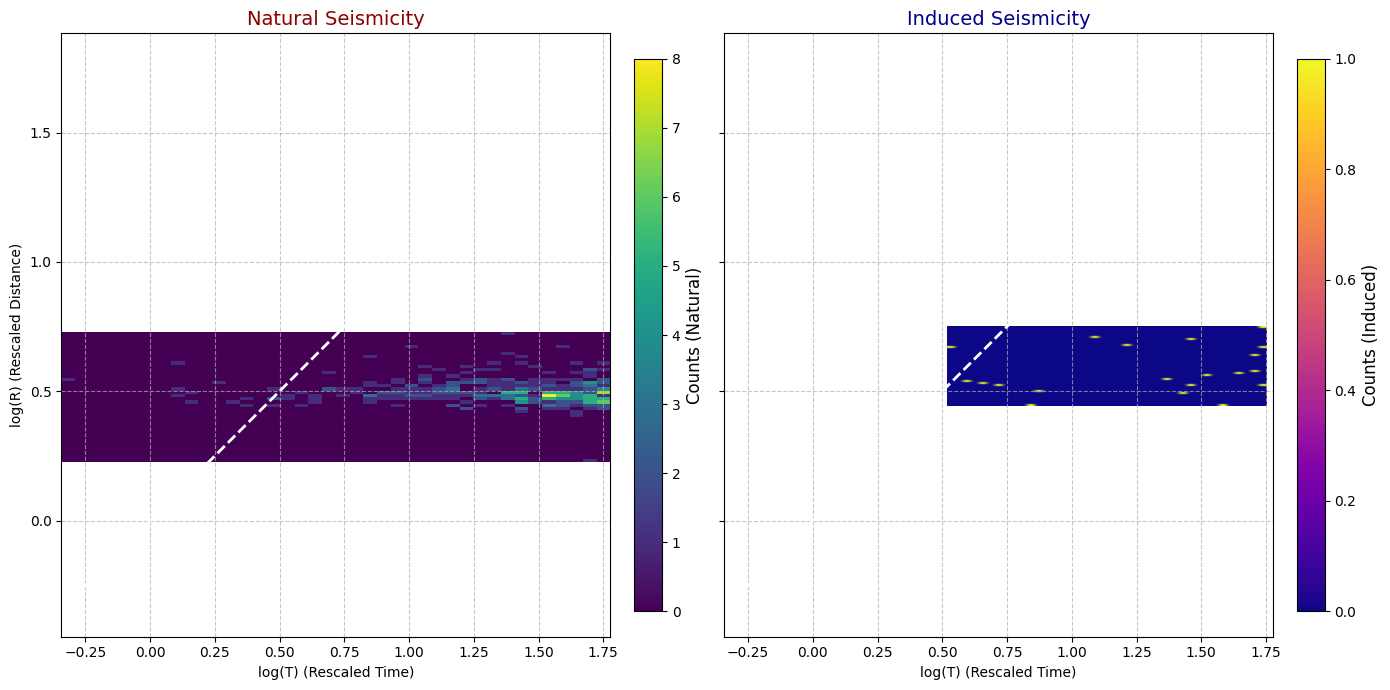

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
file_path = "BradyHypocenters.txt"
data = pd.read_csv(file_path, delim_whitespace=True)

# Periksa kolom dalam data
print("Kolom tersedia dalam data:")
print(data.columns)

# Menghitung log(T) dan log(R)
data['T'] = data['SEC']  # Gunakan 'SEC' sebagai waktu relatif
data['R'] = np.sqrt(data['X']**2 + data['Y']**2 + data['Z']**2)  # Hitung jarak spasial
data['log_T'] = np.log10(data['T'])
data['log_R'] = np.log10(data['R'])

# Menghilangkan data dengan nilai negatif atau nol (tidak valid dalam logaritma)
data = data[(data['log_T'] > -np.inf) & (data['log_R'] > -np.inf)]

# Membagi data menjadi 'natural' dan 'induced' berdasarkan MAG
data['type'] = np.where(data['MAG'] < 1, 'natural', 'induced')

# Memisahkan data berdasarkan tipe
natural_data = data[data['type'] == 'natural']
induced_data = data[data['type'] == 'induced']

# Ekstraksi log(T) dan log(R)
log_T_natural = natural_data['log_T'].values
log_R_natural = natural_data['log_R'].values
log_T_induced = induced_data['log_T'].values
log_R_induced = induced_data['log_R'].values

# Membuat histogram 2D
bins = 40  # Sesuaikan jumlah bin agar tidak terlalu sedikit/banyak
H_natural, xedges_natural, yedges_natural = np.histogram2d(log_T_natural, log_R_natural, bins=bins)
H_induced, xedges_induced, yedges_induced = np.histogram2d(log_T_induced, log_R_induced, bins=bins)

# Normalisasi histogram untuk visualisasi yang lebih baik
H_natural = H_natural.T
H_induced = H_induced.T

# Membuat subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

# Plot Natural Seismicity
im1 = axes[0].imshow(H_natural, origin='lower', aspect='auto',
                      extent=[xedges_natural[0], xedges_natural[-1], yedges_natural[0], yedges_natural[-1]],
                      cmap='viridis')
axes[0].set_title("Natural Seismicity", fontsize=14, color='darkred')
axes[0].set_xlabel("log(T) (Rescaled Time)")
axes[0].set_ylabel("log(R) (Rescaled Distance)")
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot Induced Seismicity
im2 = axes[1].imshow(H_induced, origin='lower', aspect='auto',
                      extent=[xedges_induced[0], xedges_induced[-1], yedges_induced[0], yedges_induced[-1]],
                      cmap='plasma')
axes[1].set_title("Induced Seismicity", fontsize=14, color='darkblue')
axes[1].set_xlabel("log(T) (Rescaled Time)")
axes[1].grid(True, linestyle='--', alpha=0.7)

# Menambahkan garis pembatas (log(T) = log(R))
line_x = np.linspace(xedges_natural[0], xedges_natural[-1], 100)
line_y = line_x
for ax in axes:
    ax.plot(line_x, line_y, color='white', linestyle='--', linewidth=2)

# Menambahkan colorbars
cbar1 = fig.colorbar(im1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
cbar1.set_label('Counts (Natural)', fontsize=12)
cbar2 = fig.colorbar(im2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar2.set_label('Counts (Induced)', fontsize=12)

# Menampilkan plot
plt.tight_layout()
plt.show()

C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_3688\3088799383.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)


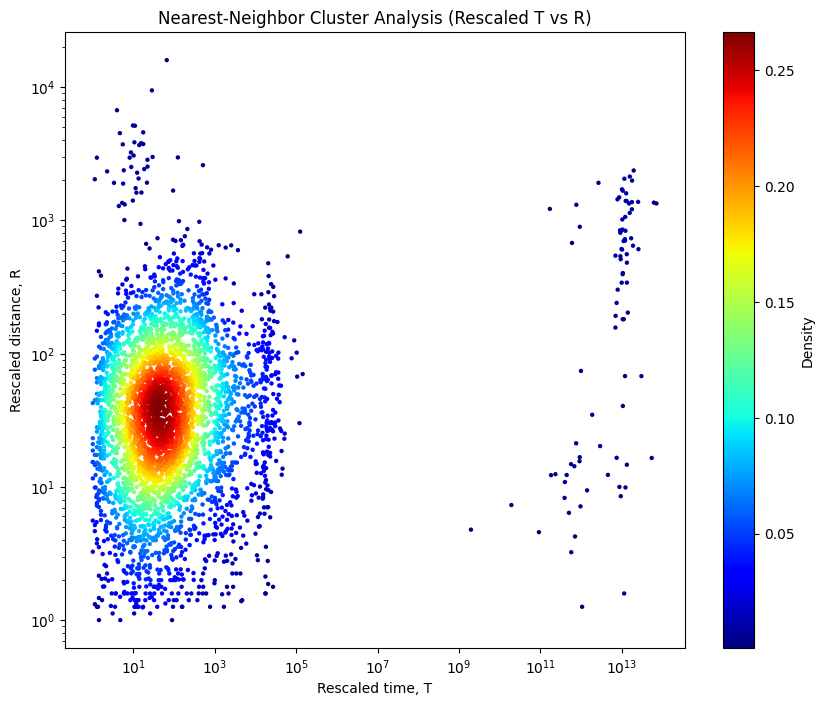

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from datetime import datetime

# Baca file data (sesuaikan path dengan lokasi file Anda)
file_path = '/TA/CODE/MEQHULULAIS.txt'  # Path file data Anda
data = pd.read_csv(file_path, delim_whitespace=True, header=None)

# Indeks kolom sesuai format yang diberikan
yeari, monthi, dayi = 0, 1, 2
houri, mini, seci = 3, 4, 5
lati, loni, depi = 6, 7, 8
magi = 9

# Ekstrak data dari file
years = data.iloc[:, yeari]
months = data.iloc[:, monthi]
days = data.iloc[:, dayi]
hours = data.iloc[:, houri]
minutes = data.iloc[:, mini]
seconds = data.iloc[:, seci]
magnitudes = data.iloc[:, magi]
latitudes = data.iloc[:, lati]
longitudes = data.iloc[:, loni]
depths = data.iloc[:, depi]

# Konversi waktu menjadi format detik
times = [
    datetime(year, month, day, hour, minute, int(second)).timestamp()
    for year, month, day, hour, minute, second in zip(years, months, days, hours, minutes, seconds)
]
times = np.array(times)

# Lokasi dalam koordinat (x, y, z)
locations = np.array([longitudes, latitudes, depths]).T

# Fungsi untuk menghitung Rescaled Time (T) dan Rescaled Distance (R)
def compute_rescaled_TR(magnitudes, times, locations, p=0.5, q=0.5):
    n_events = len(magnitudes)
    T_values = []
    R_values = []

    for i in range(1, n_events):
        # Perbedaan waktu dan lokasi terhadap event ke-i
        d_time = times[:i] - times[i]
        d_space = np.linalg.norm(locations[:i] - locations[i], axis=1)

        # Normalisasi menggunakan magnitudo
        d_mag = 10 ** (-p * magnitudes[:i])

        # Hindari nilai nol
        min_d_time = np.min(np.abs(d_time)) if np.min(np.abs(d_time)) > 0 else 1e-8
        min_d_space = np.min(d_space) if np.min(d_space) > 0 else 1e-8

        # Rescaled Time (T) dan Rescaled Distance (R)
        T = np.abs(d_time) / (min_d_time * d_mag)
        R = d_space / (min_d_space * d_mag)

        T_values.extend(T)
        R_values.extend(R)

    return np.array(T_values), np.array(R_values)

# Hitung Rescaled T dan R
T_values, R_values = compute_rescaled_TR(magnitudes, times, locations)

# Hapus nilai nol atau negatif sebelum log
valid_indices = (T_values > 0) & (R_values > 0)
T_values = T_values[valid_indices]
R_values = R_values[valid_indices]

# Membuat heatmap dengan Gaussian KDE
xy = np.vstack([np.log10(T_values), np.log10(R_values)])
kde = gaussian_kde(xy)
z = kde(xy)

# Scatter plot dengan warna sesuai densitas
plt.figure(figsize=(10, 8))
plt.scatter(T_values, R_values, c=z, s=10, cmap='jet', edgecolor='none')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='Density')
plt.xlabel('Rescaled time, T')
plt.ylabel('Rescaled distance, R')
plt.title('Nearest-Neighbor Cluster Analysis (Rescaled T vs R)')
plt.show()


C:\Users\MSI-PC\AppData\Local\Temp\ipykernel_3688\2507989244.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None)


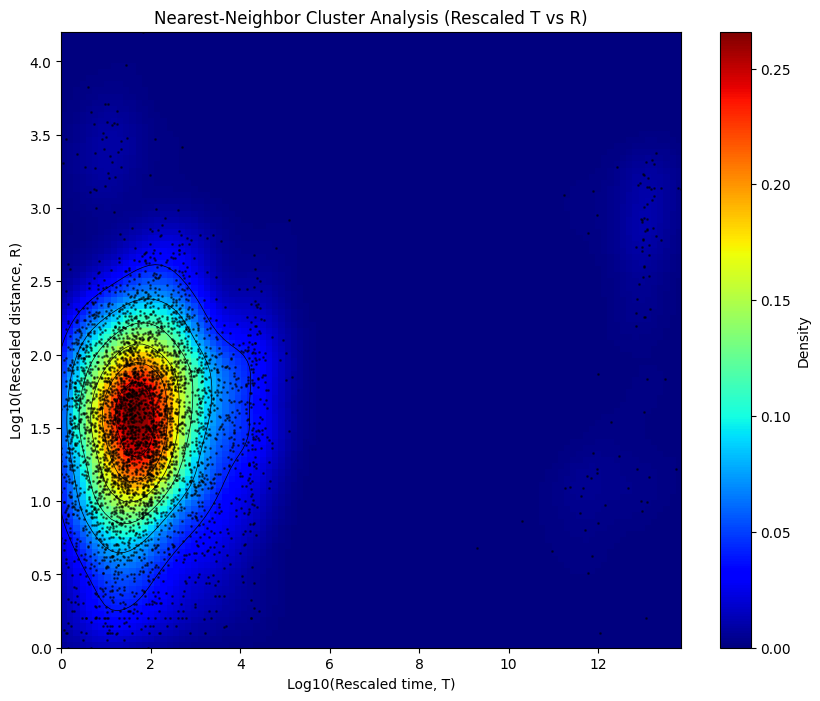

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from datetime import datetime

# Baca file data (sesuaikan path dengan lokasi file Anda)
file_path = '/TA/CODE/MEQHULULAIS.txt'  # Path file data Anda
data = pd.read_csv(file_path, delim_whitespace=True, header=None)

# Indeks kolom sesuai format yang diberikan
yeari, monthi, dayi = 0, 1, 2
houri, mini, seci = 3, 4, 5
lati, loni, depi = 6, 7, 8
magi = 9

# Ekstrak data dari file
years = data.iloc[:, yeari]
months = data.iloc[:, monthi]
days = data.iloc[:, dayi]
hours = data.iloc[:, houri]
minutes = data.iloc[:, mini]
seconds = data.iloc[:, seci]
magnitudes = data.iloc[:, magi]
latitudes = data.iloc[:, lati]
longitudes = data.iloc[:, loni]
depths = data.iloc[:, depi]

# Konversi waktu menjadi format detik
times = [
    datetime(year, month, day, hour, minute, int(second)).timestamp()
    for year, month, day, hour, minute, second in zip(years, months, days, hours, minutes, seconds)
]
times = np.array(times)

# Lokasi dalam koordinat (x, y, z)
locations = np.array([longitudes, latitudes, depths]).T

# Fungsi untuk menghitung Rescaled Time (T) dan Rescaled Distance (R)
def compute_rescaled_TR(magnitudes, times, locations, p=0.5, q=0.5):
    n_events = len(magnitudes)
    T_values = []
    R_values = []

    for i in range(1, n_events):
        # Perbedaan waktu dan lokasi terhadap event ke-i
        d_time = times[:i] - times[i]
        d_space = np.linalg.norm(locations[:i] - locations[i], axis=1)

        # Normalisasi menggunakan magnitudo
        d_mag = 10 ** (-p * magnitudes[:i])

        # Hindari nilai nol
        min_d_time = np.min(np.abs(d_time)) if np.min(np.abs(d_time)) > 0 else 1e-8
        min_d_space = np.min(d_space) if np.min(d_space) > 0 else 1e-8

        # Rescaled Time (T) dan Rescaled Distance (R)
        T = np.abs(d_time) / (min_d_time * d_mag)
        R = d_space / (min_d_space * d_mag)

        T_values.extend(T)
        R_values.extend(R)

    return np.array(T_values), np.array(R_values)

# Hitung Rescaled T dan R
T_values, R_values = compute_rescaled_TR(magnitudes, times, locations)

# Hapus nilai nol atau negatif sebelum log
valid_indices = (T_values > 0) & (R_values > 0)
T_values = T_values[valid_indices]
R_values = R_values[valid_indices]

# Membuat grid untuk heatmap
x = np.log10(T_values)
y = np.log10(R_values)

# Membuat heatmap dengan Gaussian KDE
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(
    np.rot90(Z),
    extent=[xmin, xmax, ymin, ymax],
    cmap='jet',
    aspect='auto'
)
plt.colorbar(label='Density')
plt.contour(X, Y, Z, colors='black', linewidths=0.5)
plt.scatter(x, y, c='black', s=1, alpha=0.5)  # Data points
plt.xlabel('Log10(Rescaled time, T)')
plt.ylabel('Log10(Rescaled distance, R)')
plt.title('Nearest-Neighbor Cluster Analysis (Rescaled T vs R)')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Path file
file_path = "BradyHypocenters.txt"  # Ganti dengan path file Anda

# Membaca file dengan mengabaikan baris yang salah
data = np.genfromtxt(
    file_path,
    dtype=None,
    encoding=None,
    delimiter=None,
    names=True,
    invalid_raise=False  # Abaikan baris dengan jumlah kolom salah
)

# Periksa nama kolom untuk debugging
print("Kolom yang terbaca:", data.dtype.names)

# Ekstrak koordinat (X_km, Y_km, Z_km) dari kolom yang benar
try:
    x = data['X'] 
    y = data['Y'] 
    z = data['Z'] 


# Gabungkan koordinat dalam array 3D
coordinates = np.vstack((x, y, z)).T

# Hitung matriks jarak
distance_matrix = squareform(pdist(coordinates))

# Pilih nilai epsilon (radius) untuk correlation integral
epsilons = np.logspace(-2, 1, 50)  # Rentang epsilon dalam skala log
log_epsilons = np.log10(epsilons)

# Hitung correlation integral C(epsilon)
C_eps = []
for epsilon in epsilons:
    count = np.sum(distance_matrix < epsilon) - len(distance_matrix)  # Hitung pasangan r_ij < epsilon
    C_eps.append(count / (len(distance_matrix) * (len(distance_matrix) - 1)))

# Konversi ke log-log
log_C_eps = np.log10(C_eps)

# Hitung dimensi korelasi
dimension = np.gradient(log_C_eps, log_epsilons)

# Plot hasil
plt.figure(figsize=(8, 6))
plt.plot(log_epsilons, dimension, label='Study Area', color='blue', linewidth=2)
plt.axvline(x=-1, color='gray', linestyle='--', label='$r_{min}$')
plt.xlabel('log(r) (km)', fontsize=12)
plt.ylabel('Correlation Dimension', fontsize=12)
plt.title('Correlation Dimension vs log(r)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Data dummy hiposenter (x, y, z) dalam kilometer
hiposenter = np.array([
    [0, 0, 0],  # Hiposenter 1
    [1, 1, 1],  # Hiposenter 2
    [2, 2, 2],  # Hiposenter 3
    [1, 2, 0],  # Hiposenter 4
    [3, 1, 1]   # Hiposenter 5
])

# Total jumlah gempa
N = len(hiposenter)

# Fungsi untuk menghitung jarak Euclidean
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

# Hitung semua kombinasi pasangan (i, j)
pairs = list(combinations(range(N), 2))
distances = [euclidean_distance(hiposenter[i], hiposenter[j]) for i, j in pairs]

# Pilih nilai r (radius)
r_values = np.logspace(-1.5, 1.5, 50)  # Dari 0.03 km hingga 31.6 km
C_r = []

for r in r_values:
    # Hitung N(r_0 < r)
    N_r = sum(1 for d in distances if d < r)
    # Hitung C(r) menggunakan rumus
    C_r.append(2 * N_r / (N * (N - 1)))

# Plot C(r) dalam skala log-log
plt.figure(figsize=(8, 6))
plt.loglog(r_values, C_r, label='Correlation function', color='blue', linewidth=2)
plt.xlabel('log(r) (km)', fontsize=12)
plt.ylabel('C(r)', fontsize=12)
plt.title('Correlation Function vs Distance', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [2]:
import numpy as np

def is_leap_year(year):
    """Check if a year is a leap year."""
    return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

def add_date(date):
    """
    Add missing dates in the input date array.
    Format of the date is [YEAR, MONTH, DAY], dates must
    be ordered in descending order.

    Args:
        date (numpy.ndarray): Input array of dates, shape (n, 3)
    
    Returns:
        tuple: (fulldate, indexes)
            - fulldate (numpy.ndarray): Array with all dates filled in.
            - indexes (list): Indexes of original dates within the full date array.
    """
    # Leap and regular year's days
    V = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # Leap year
    NV = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # Regular year

    L = date.shape[0]
    I = list(range(L))

    i = 0
    e = 1
    while i < len(date) - 1:
        d = (np.datetime64(f"{date[i + 1, 0]}-{date[i + 1, 1]:02d}-{date[i + 1, 2]:02d}") -
             np.datetime64(f"{date[i, 0]}-{date[i, 1]:02d}-{date[i, 2]:02d}")).astype(int)

        if d > 0:
            raise ValueError(f"Date must be ordered descendingly: case {date[i]}")

        if d == 0:
            # Remove duplicate date
            date = np.delete(date, i + 1, axis=0)
            continue

        d = -d - 1
        date1 = date[i].copy()
        new_dates = []

        for _ in range(d):
            if date1[2] != 1:
                # Not the 1st day of the month
                date1[2] -= 1
            else:
                # 1st day of the month
                if date1[1] == 1:
                    # January 1st
                    date1 = [date1[0] - 1, 12, 31]
                else:
                    days_in_month = V if is_leap_year(date1[0]) else NV
                    date1 = [date1[0], date1[1] - 1, days_in_month[date1[1] - 2]]

            new_dates.append(date1.copy())

        date = np.insert(date, i + 1, new_dates, axis=0)
        i += 1 + d

        I[e:] = [x + d for x in I[e:]]
        e += 1

    return date, I

# Example usage
# date_array = np.array([[2023, 3, 5], [2023, 3, 2]])
# fulldate, indexes = add_date(date_array)
# print("Full Dates:", fulldate)
# print("Indexes:", indexes)